In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
import seaborn as sns


from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model
import newmodel
import diffmodel
import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [49]:
import importlib 
importlib.reload(diffmodel)

<module 'diffmodel' from '/storage/hive/project/cse-vuduc/zzhang834/CFRM/src/diffmodel.py'>

In [50]:
dir = '../data/simulated/'

path = '2b5c_sigma0.1_b1_1/'

counts_rna = pd.read_csv(os.path.join(dir + path, 'GxC1.txt'), sep = "\t", header = None).values.T
counts_atac = pd.read_csv(os.path.join(dir + path, 'RxC2.txt'), sep = "\t", header = None).values.T
A = pd.read_csv(os.path.join(dir + path, 'region2gene.txt'), sep = "\t", header = None).values.T

counts_rna = np.array(counts_rna)
counts_atac = np.array(counts_atac)
A = np.array(A)


label_rna = pd.read_csv(os.path.join(dir + path, "cell_label1.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()
label_atac = pd.read_csv(os.path.join(dir + path, "cell_label2.txt"), index_col=0, sep = "\t")["pop"].values.squeeze()

# counts_atac = counts_atac[np.where(label_atac != 1)[0],:]
# label_atac = label_atac[np.where(label_atac != 1)[0]]

counts = {"rna":[counts_rna], "atac": [counts_atac], "gact": [A]}

In [51]:
# train model
model1 = diffmodel.cfrm_diff(counts, N1 = 5, N2 = 5, K = 5, batch_size = 0.3, interval=100, lr=1e-3, 
                            alpha = [1000, 1000, 10, 10, 1, 10, 1], seed = 0, learn_gact = False).to(device)

model1.train_func(T = 7000)


Epoch 100, Validating Loss: 73.7238
	 loss 1: 34.60619
	 loss 2: 58.77575
	 loss 3: -9.99998
	 loss 4: -9.65810
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoch 200, Validating Loss: 73.6168
	 loss 1: 34.61506
	 loss 2: 58.78759
	 loss 3: -9.99998
	 loss 4: -9.78584
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoch 300, Validating Loss: 73.4620
	 loss 1: 34.54777
	 loss 2: 58.77138
	 loss 3: -9.99976
	 loss 4: -9.85742
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoch 400, Validating Loss: 73.2544
	 loss 1: 34.43676
	 loss 2: 58.69143
	 loss 3: -9.99473
	 loss 4: -9.87902
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoch 500, Validating Loss: 71.9364
	 loss 1: 33.36054
	 loss 2: 58.31314
	 loss 3: -9.93426
	 loss 4: -9.80302
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoch 600, Validating Loss: 67.6050
	 loss 1: 30.05835
	 loss 2: 56.95573
	 loss 3: -9.83313
	 loss 4: -9.57596
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoc

Epoch 5000, Validating Loss: 9.3999
	 loss 1: 19.13122
	 loss 2: 34.51959
	 loss 3: -9.99773
	 loss 4: -9.53924
	 loss 5: 0.00000
	 loss 6: -23.72537
	 loss 7: -0.98853
Epoch 5100, Validating Loss: 9.3404
	 loss 1: 19.12553
	 loss 2: 34.51602
	 loss 3: -9.99825
	 loss 4: -9.54691
	 loss 5: 0.00000
	 loss 6: -23.76873
	 loss 7: -0.98731
Epoch 5200, Validating Loss: 9.2731
	 loss 1: 19.12462
	 loss 2: 34.50415
	 loss 3: -9.99879
	 loss 4: -9.55410
	 loss 5: 0.00000
	 loss 6: -23.81713
	 loss 7: -0.98564
Epoch 5300, Validating Loss: 9.2286
	 loss 1: 19.12988
	 loss 2: 34.50013
	 loss 3: -9.99911
	 loss 4: -9.56158
	 loss 5: 0.00000
	 loss 6: -23.85609
	 loss 7: -0.98461
Epoch 5400, Validating Loss: 9.1659
	 loss 1: 19.12533
	 loss 2: 34.49463
	 loss 3: -9.99926
	 loss 4: -9.56855
	 loss 5: 0.00000
	 loss 6: -23.90276
	 loss 7: -0.98349
Epoch 5500, Validating Loss: 9.1207
	 loss 1: 19.12577
	 loss 2: 34.49265
	 loss 3: -9.99931
	 loss 4: -9.57625
	 loss 5: 0.00000
	 loss 6: -23.93988
	 los

In [52]:
z_rna = model1.softmax(model1.C_1).cpu().detach().numpy()
z_atac = model1.softmax(model1.C_2).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

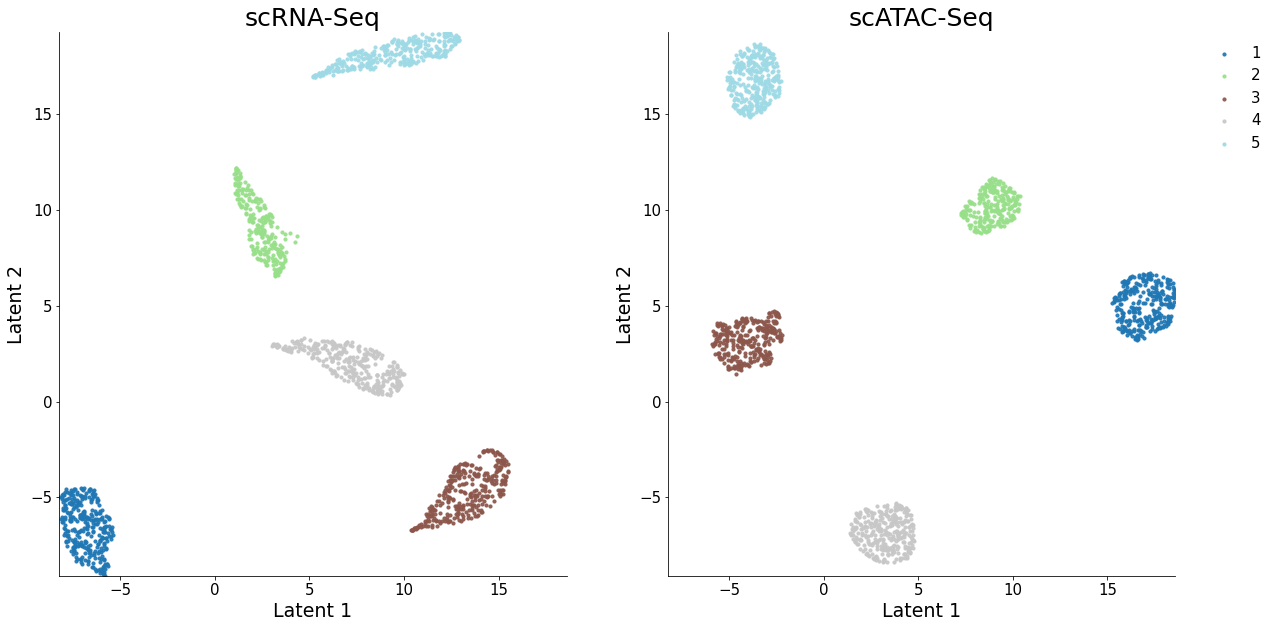

In [53]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

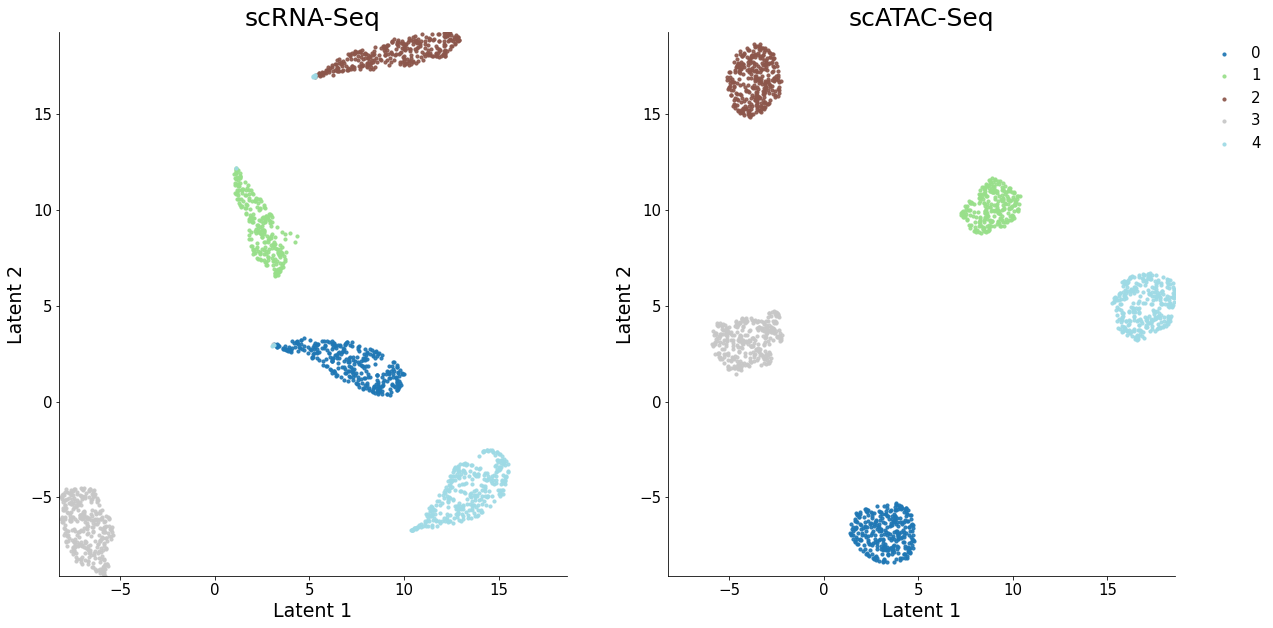

In [54]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], max_rna, max_atac, mode= "separate", save = None)

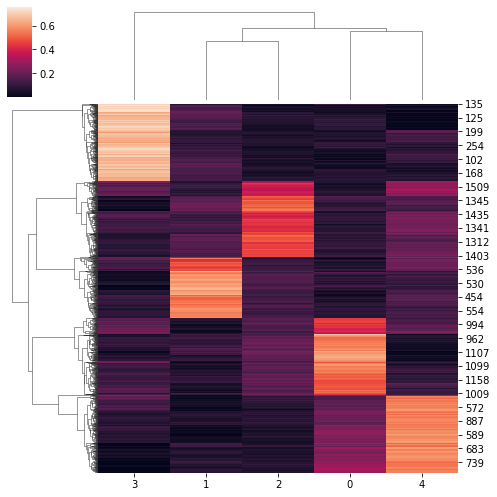

In [59]:
g = sns.clustermap(z_rna, figsize = (7,7))

In [61]:
g.savefig("pic.png")

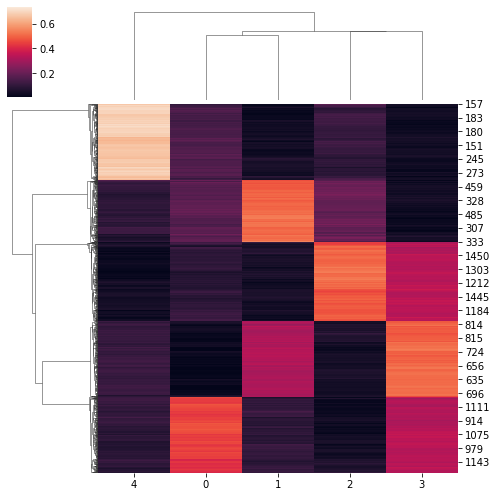

In [56]:
_ = sns.clustermap(z_atac, figsize = (7,7))

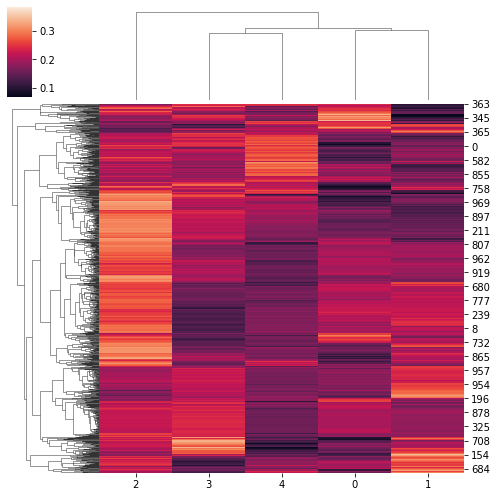

In [57]:
z_g = model1.softmax(model1.C_g).cpu().detach().numpy()
z_r = model1.softmax(model1.C_r).cpu().detach().numpy()
_ = sns.clustermap(z_g, figsize = (7,7))

/storage/home/hhive1/zzhang834/.conda/envs/myenv/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


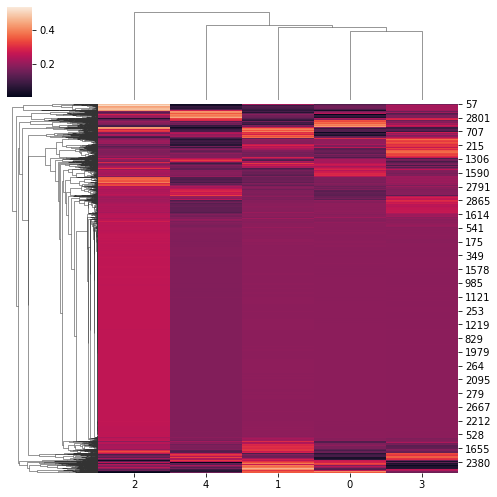

In [58]:
_ = sns.clustermap(z_r, figsize = (7,7))

In [65]:
# train model
model1 = newmodel.cfrm_new2(counts, N = 5, batch_size = 0.3, interval=100, lr=1e-3, 
                            alpha = [1000, 1000, 100, 100, 1, 1], seed = 0).to(device)

model1.train_func(T = 7000)



Epoch 100, Validating Loss: -102.1365
	 loss 1: 34.72479
	 loss 2: 58.87460
	 loss 3: -99.99996
	 loss 4: -96.72677
	 loss 5: 0.99085
Epoch 200, Validating Loss: -103.4435
	 loss 1: 34.69695
	 loss 2: 58.82890
	 loss 3: -99.99995
	 loss 4: -97.94691
	 loss 5: 0.97754
Epoch 300, Validating Loss: -104.2326
	 loss 1: 34.63186
	 loss 2: 58.71534
	 loss 3: -99.99995
	 loss 4: -98.54485
	 loss 5: 0.96503
Epoch 400, Validating Loss: -104.7329
	 loss 1: 34.66265
	 loss 2: 58.42566
	 loss 3: -99.99957
	 loss 4: -98.77509
	 loss 5: 0.95348
Epoch 500, Validating Loss: -105.7651
	 loss 1: 34.59523
	 loss 2: 57.48053
	 loss 3: -99.99541
	 loss 4: -98.78866
	 loss 5: 0.94323
Epoch 600, Validating Loss: -107.6976
	 loss 1: 34.56921
	 loss 2: 55.46226
	 loss 3: -99.97470
	 loss 4: -98.68921
	 loss 5: 0.93482
Epoch 700, Validating Loss: -110.5617
	 loss 1: 34.52196
	 loss 2: 52.49700
	 loss 3: -99.95408
	 loss 4: -98.55602
	 loss 5: 0.92942
Epoch 800, Validating Loss: -113.6152
	 loss 1: 34.34386
	 los

Epoch 6200, Validating Loss: -138.7167
	 loss 1: 20.49953
	 loss 2: 37.62914
	 loss 3: -99.99908
	 loss 4: -97.86670
	 loss 5: 1.02043
Epoch 6300, Validating Loss: -138.6880
	 loss 1: 20.50338
	 loss 2: 37.61895
	 loss 3: -99.99908
	 loss 4: -97.83019
	 loss 5: 1.01890
Epoch 6400, Validating Loss: -138.7188
	 loss 1: 20.49915
	 loss 2: 37.61248
	 loss 3: -99.99898
	 loss 4: -97.85312
	 loss 5: 1.02170
Epoch 6500, Validating Loss: -138.7421
	 loss 1: 20.49611
	 loss 2: 37.61616
	 loss 3: -99.99877
	 loss 4: -97.88071
	 loss 5: 1.02515
Epoch 6600, Validating Loss: -138.7693
	 loss 1: 20.49641
	 loss 2: 37.59566
	 loss 3: -99.99853
	 loss 4: -97.88984
	 loss 5: 1.02694
Epoch 6700, Validating Loss: -138.7916
	 loss 1: 20.49832
	 loss 2: 37.59009
	 loss 3: -99.99817
	 loss 4: -97.91222
	 loss 5: 1.03041
Epoch 6800, Validating Loss: -138.8043
	 loss 1: 20.50481
	 loss 2: 37.57646
	 loss 3: -99.99779
	 loss 4: -97.92010
	 loss 5: 1.03236
Epoch 6900, Validating Loss: -138.8138
	 loss 1: 20.501

In [69]:
z_rna = model1.softmax(model1.C_1).cpu().detach().numpy()
z_atac = model1.softmax(model1.C_2).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

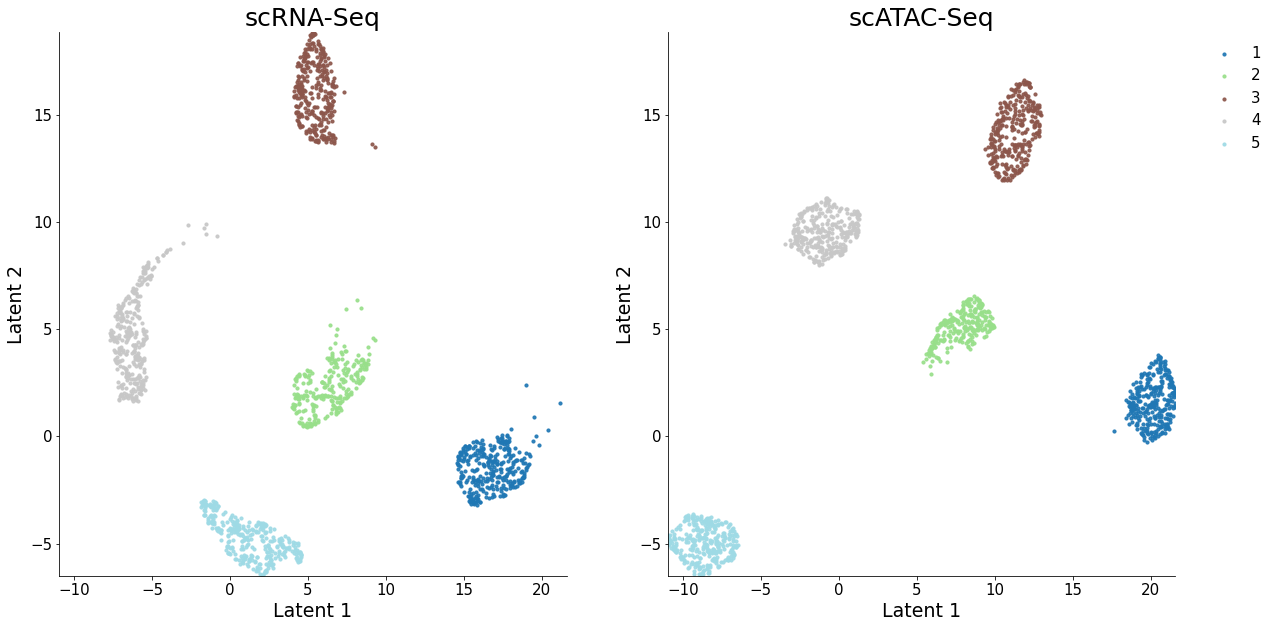

In [67]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

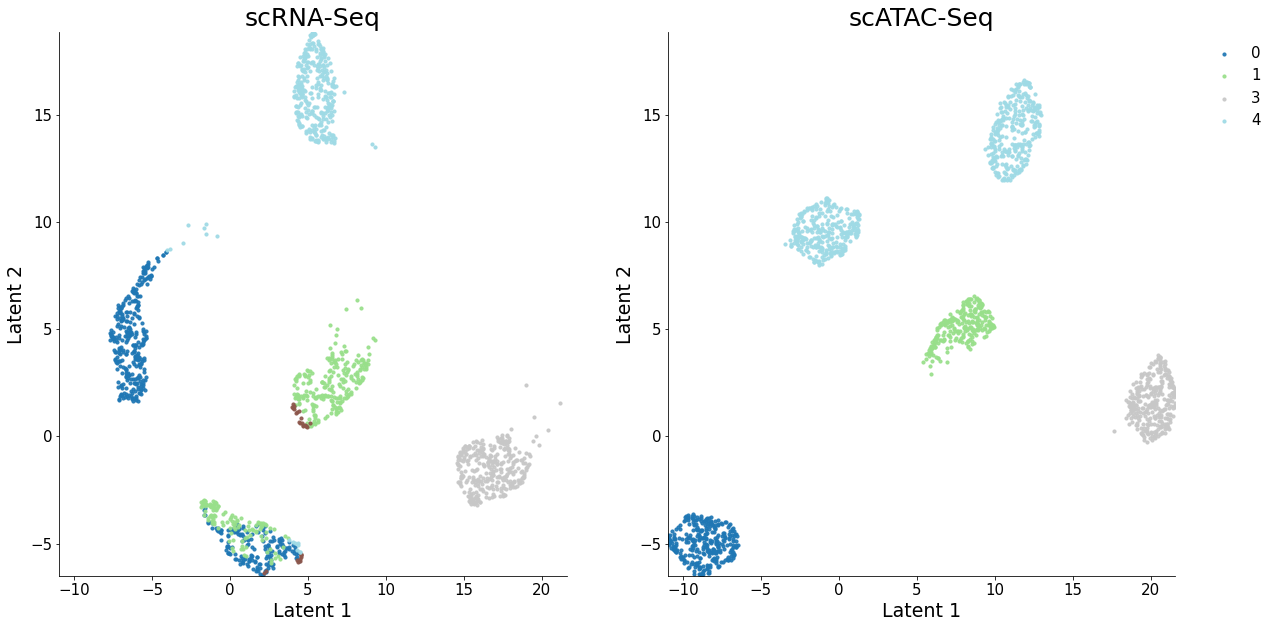

In [68]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], max_rna, max_atac, mode= "separate", save = None)

In [70]:
# train model
model1 = model.cfrm_new(counts, N = 5, batch_size = 0.3, interval=100, lr=1e-3, 
                        alpha = [1000, 1000, 100, 100, 1, 1], seed = 0).to(device)

model1.train_func(T = 7000)




Epoch 100, Validating Loss: -102.9554
	 loss 1: 34.69881
	 loss 2: 58.87930
	 loss 3: -99.99998
	 loss 4: -96.53352
Epoch 200, Validating Loss: -104.2332
	 loss 1: 34.71497
	 loss 2: 58.87131
	 loss 3: -99.99993
	 loss 4: -97.81953
Epoch 300, Validating Loss: -105.1513
	 loss 1: 34.66320
	 loss 2: 58.79150
	 loss 3: -99.99998
	 loss 4: -98.60597
Epoch 400, Validating Loss: -105.7386
	 loss 1: 34.62789
	 loss 2: 58.71087
	 loss 3: -99.99993
	 loss 4: -99.07738
Epoch 500, Validating Loss: -106.2425
	 loss 1: 34.61373
	 loss 2: 58.48141
	 loss 3: -99.99968
	 loss 4: -99.33792
Epoch 600, Validating Loss: -107.0832
	 loss 1: 34.56239
	 loss 2: 57.81968
	 loss 3: -99.99763
	 loss 4: -99.46767
Epoch 700, Validating Loss: -108.6911
	 loss 1: 34.47683
	 loss 2: 56.32495
	 loss 3: -99.98717
	 loss 4: -99.50574
Epoch 800, Validating Loss: -111.4061
	 loss 1: 34.30471
	 loss 2: 53.72729
	 loss 3: -99.96672
	 loss 4: -99.47140
Epoch 900, Validating Loss: -114.9884
	 loss 1: 33.81089
	 loss 2: 50.53

In [71]:
z_rna = model1.softmax(model1.C_1).cpu().detach().numpy()
z_atac = model1.softmax(model1.C_2).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

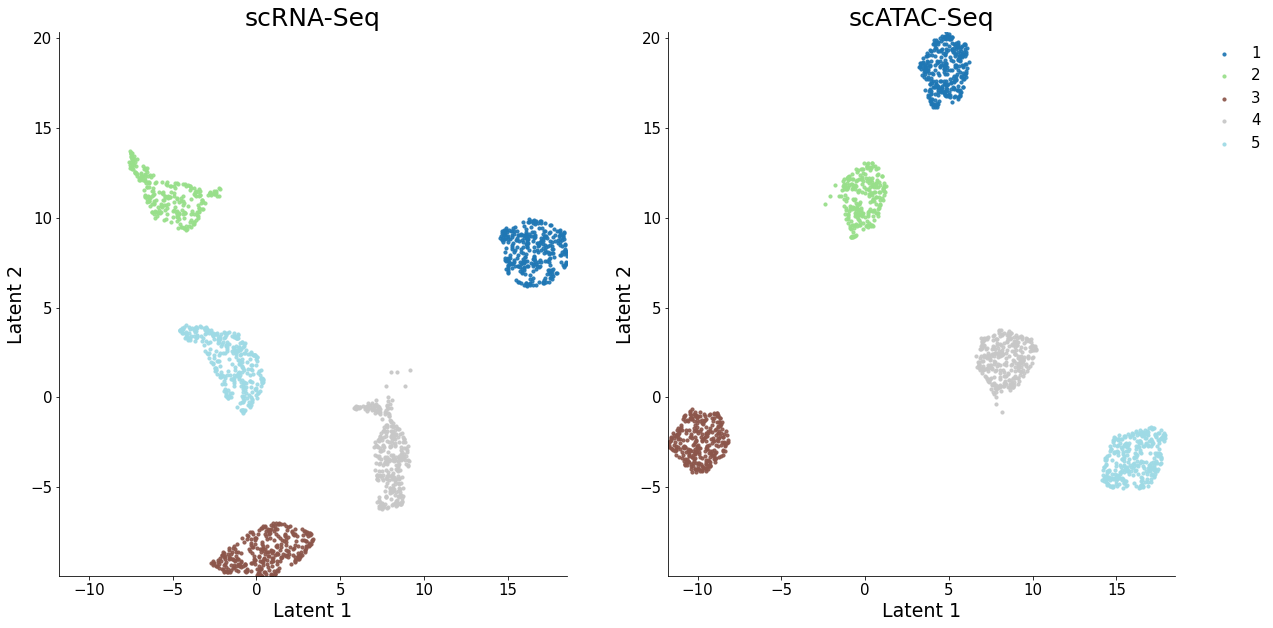

In [72]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

In [38]:
# train model
model1 = diffmodel.cfrm_diff(counts, N1 = 5, N2 = 5, K = 5, batch_size = 0.3, interval=100, lr=1e-3, 
                            alpha = [1000, 1000, 10, 10, 1, 10, 0], seed = 0, learn_gact = False).to(device)

model1.train_func(T = 7000)



Epoch 100, Validating Loss: 73.8155
	 loss 1: 34.64378
	 loss 2: 58.83343
	 loss 3: -9.99872
	 loss 4: -9.66298
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoch 200, Validating Loss: 73.5712
	 loss 1: 34.56361
	 loss 2: 58.78874
	 loss 3: -9.99887
	 loss 4: -9.78231
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoch 300, Validating Loss: 72.6914
	 loss 1: 33.91831
	 loss 2: 58.56068
	 loss 3: -9.98459
	 loss 4: -9.80299
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoch 400, Validating Loss: 69.0553
	 loss 1: 31.05423
	 loss 2: 57.53352
	 loss 3: -9.86079
	 loss 4: -9.67169
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoch 500, Validating Loss: 63.7302
	 loss 1: 28.59946
	 loss 2: 54.57404
	 loss 3: -9.93200
	 loss 4: -9.51135
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoch 600, Validating Loss: 59.9522
	 loss 1: 27.89460
	 loss 2: 51.45816
	 loss 3: -9.98614
	 loss 4: -9.41441
	 loss 5: 0.00000
	 loss 6: 0.00000
	 loss 7: 0.00000
Epoc

Epoch 5000, Validating Loss: 16.1654
	 loss 1: 24.23460
	 loss 2: 43.63636
	 loss 3: -9.99875
	 loss 4: -9.69473
	 loss 5: 0.00000
	 loss 6: -32.01206
	 loss 7: 0.00000
Epoch 5100, Validating Loss: 16.1428
	 loss 1: 24.21528
	 loss 2: 43.63622
	 loss 3: -9.99932
	 loss 4: -9.69855
	 loss 5: 0.00000
	 loss 6: -32.01080
	 loss 7: 0.00000
Epoch 5200, Validating Loss: 16.1422
	 loss 1: 24.22882
	 loss 2: 43.62731
	 loss 3: -9.99923
	 loss 4: -9.70252
	 loss 5: 0.00000
	 loss 6: -32.01220
	 loss 7: 0.00000
Epoch 5300, Validating Loss: 16.1569
	 loss 1: 24.23448
	 loss 2: 43.63359
	 loss 3: -9.99924
	 loss 4: -9.70364
	 loss 5: 0.00000
	 loss 6: -32.00831
	 loss 7: 0.00000
Epoch 5400, Validating Loss: 16.1548
	 loss 1: 24.22941
	 loss 2: 43.64291
	 loss 3: -9.99918
	 loss 4: -9.70715
	 loss 5: 0.00000
	 loss 6: -32.01117
	 loss 7: 0.00000
Epoch 5500, Validating Loss: 16.1358
	 loss 1: 24.22992
	 loss 2: 43.63238
	 loss 3: -9.99872
	 loss 4: -9.71273
	 loss 5: 0.00000
	 loss 6: -32.01507
	 lo

In [39]:
z_rna = model1.softmax(model1.C_1).cpu().detach().numpy()
z_atac = model1.softmax(model1.C_2).cpu().detach().numpy()

max_rna = np.argmax(z_rna, axis = 1).squeeze()
max_atac = np.argmax(z_atac, axis = 1).squeeze()

umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))

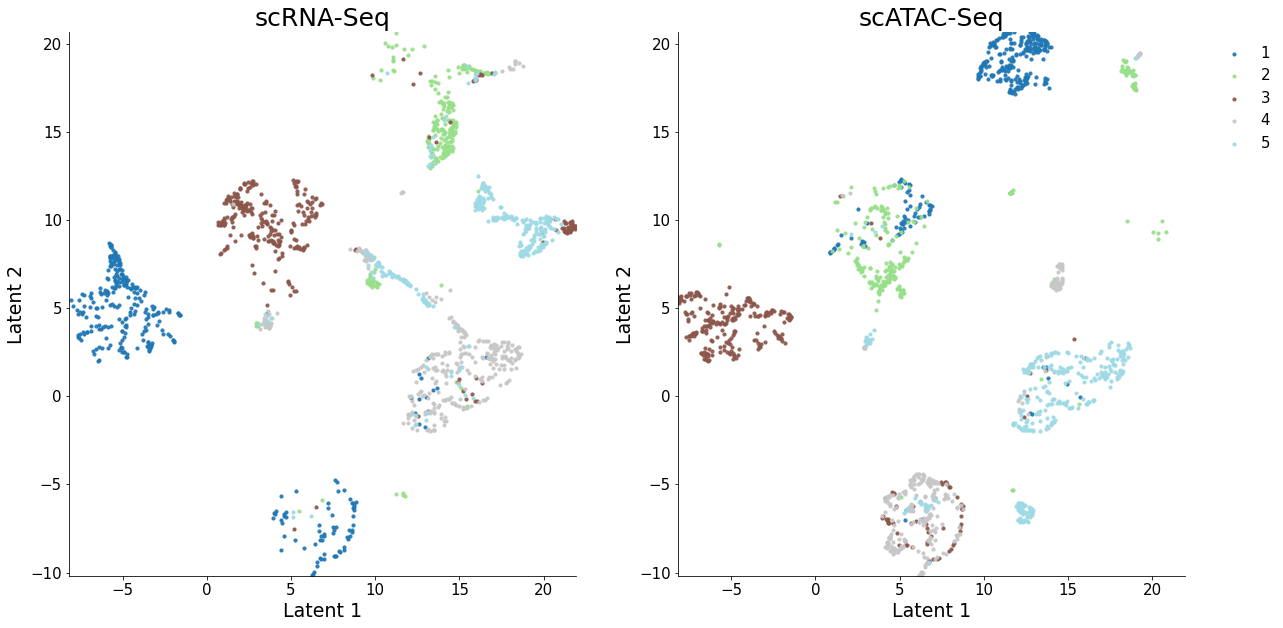

In [40]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], label_rna, label_atac, mode= "separate", save = None)

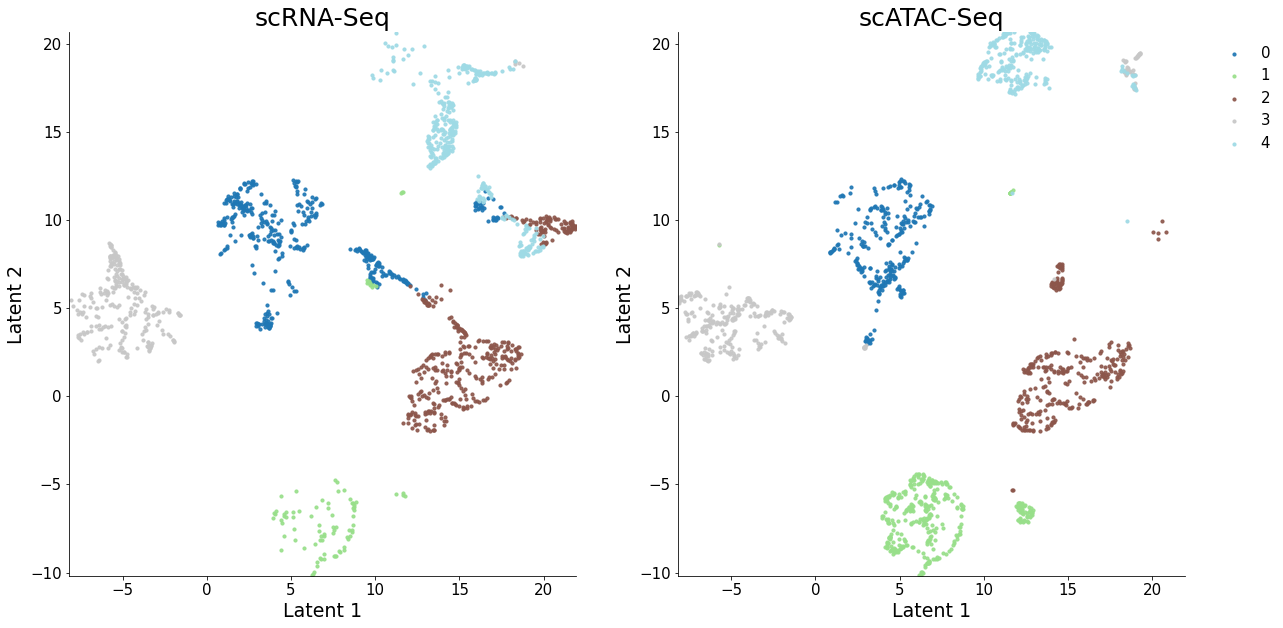

In [41]:
utils.plot_latent(z[:z_rna.shape[0],:], z[z_rna.shape[0]:,:], max_rna, max_atac, mode= "separate", save = None)

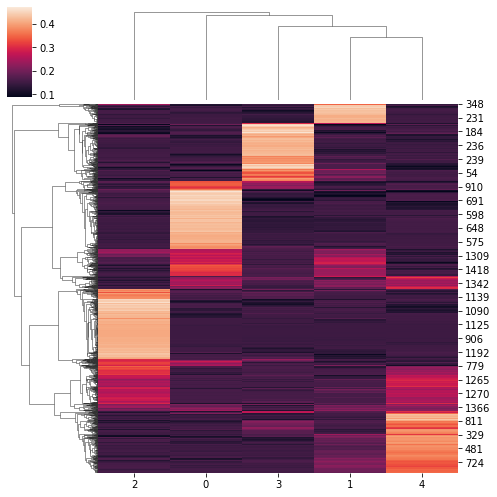

In [42]:
_ = sns.clustermap(z_rna, figsize = (7,7))

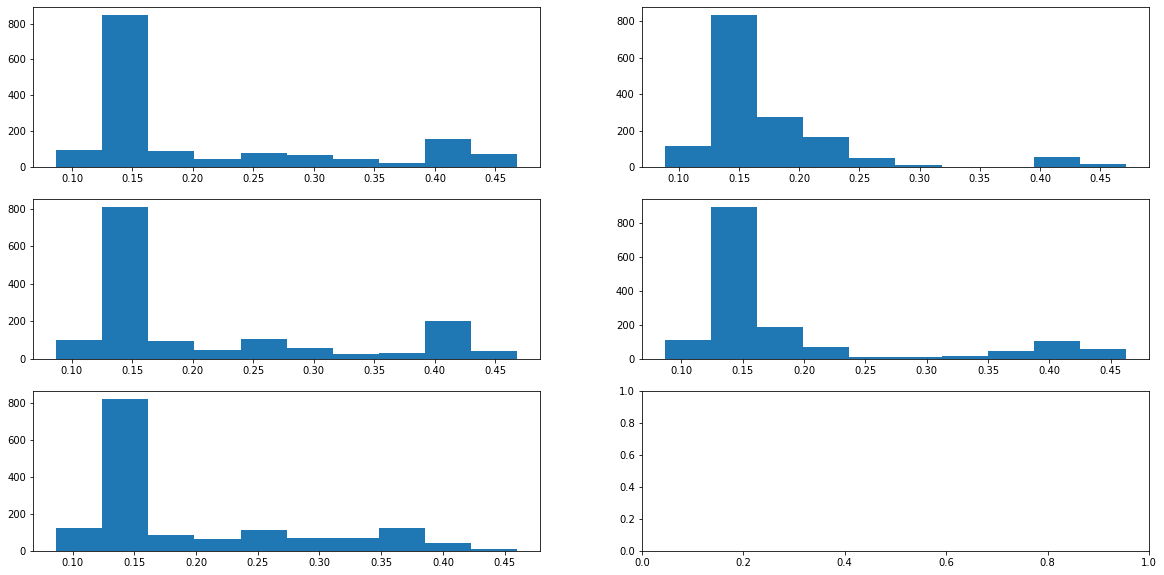

In [43]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(3,2)
_ = axs[0,0].hist(z_rna[:,0])
_ = axs[0,1].hist(z_rna[:,1])
_ = axs[1,0].hist(z_rna[:,2])
_ = axs[1,1].hist(z_rna[:,3])
_ = axs[2,0].hist(z_rna[:,4])

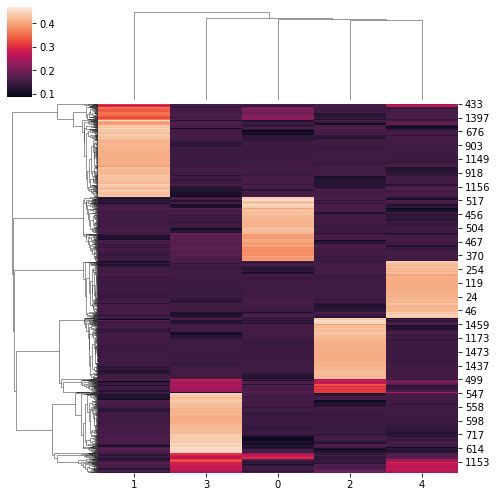

In [44]:
_ = sns.clustermap(z_atac, figsize = (7,7))

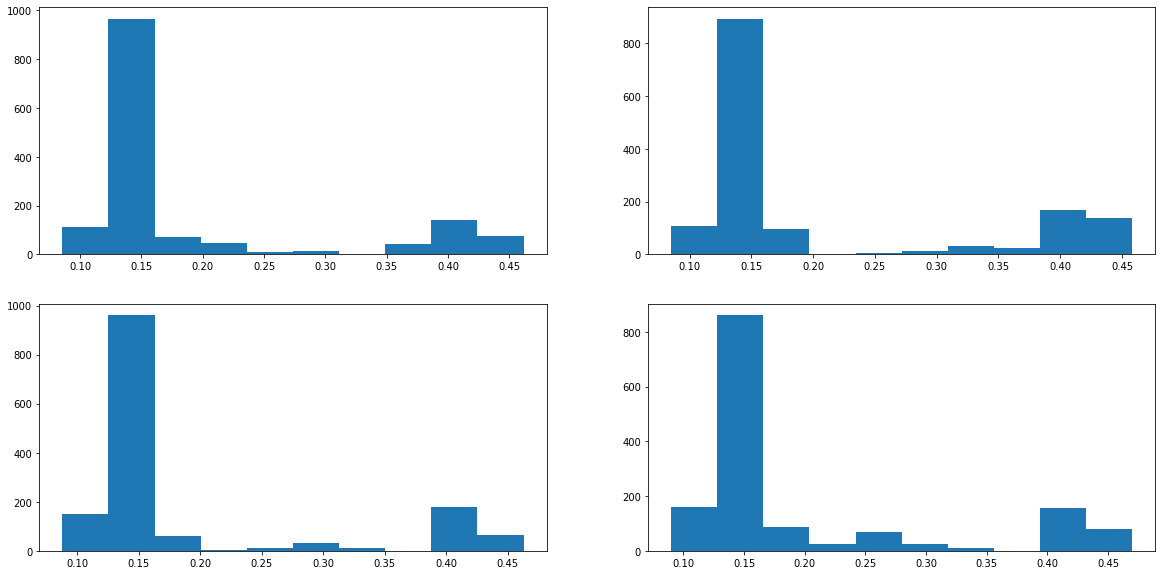

In [45]:
fig = plt.figure(figsize = (20,10))
axs = fig.subplots(2,2)
_ = axs[0,0].hist(z_atac[:,0])
_ = axs[0,1].hist(z_atac[:,1])
_ = axs[1,0].hist(z_atac[:,2])
_ = axs[1,1].hist(z_atac[:,3])


In [46]:
z_g = model1.softmax(model1.C_g).cpu().detach().numpy()
z_r = model1.softmax(model1.C_r).cpu().detach().numpy()

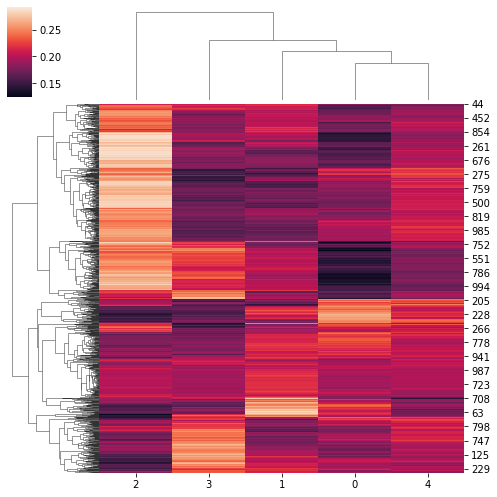

In [47]:
_ = sns.clustermap(z_g, figsize = (7,7))

/storage/home/hhive1/zzhang834/.conda/envs/myenv/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


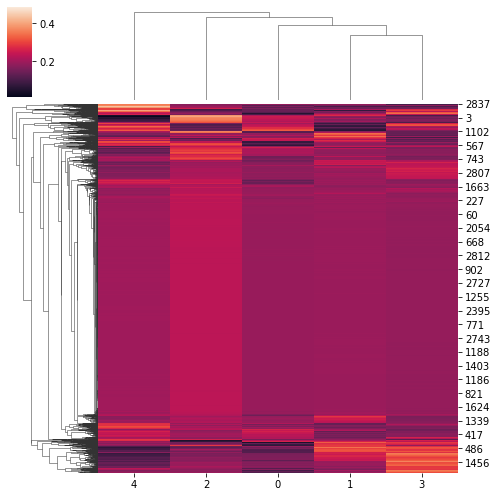

In [48]:
_ = sns.clustermap(z_r, figsize = (7,7))